In [1]:
!pip3 install --upgrade pip
!pip3 install tensorflow matplotlib numpy

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
import tensorflow as tf
import numpy as np
import os, time
import matplotlib.pyplot as plt
from datetime import datetime
from packaging import version
%matplotlib inline
# Load the TensorBoard notebook extension.
%load_ext tensorboard

import publicMethod

Import publicMethod


In [3]:
# tf.keras.optimizers.Optimizer?
# tf.keras.optimizers.SGD?
# tf.keras.optimizers.Adam?
# tf.saved_model.save?
# tf.saved_model.load?

print("TensorFlow version: ", tf.__version__, "\nDevice avaliable now:",tf.config.get_visible_devices())
assert version.parse(tf.__version__).release[0] >= 2, \
"This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.4.1 
Device avaliable now: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [5]:
LOAD_PATH = "./npy/"
SITE_CODE = "722860"
PROJECT_PATH = "tf_model_compare_params"
time = datetime.now().strftime("""%Y%m%d-%H%M%S""")
SAVE_PATH = f"{PROJECT_PATH}/tf_model_params_relu_{SITE_CODE}_{time}"
try:
    os.mkdir(PROJECT_PATH)
    os.mkdir(SAVE_PATH)
    os.mkdir(SAVE_PATH+"/fig")
except: pass

paths = []
for dirname, _, filenames in os.walk(LOAD_PATH):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
print(paths)

['./npy/avg_b_722860.npy', './npy/.DS_Store', './npy/max_722860.npy', './npy/min_745700.npy', './npy/avg_722860.npy', './npy/min_722860.npy', './npy/max_745700.npy', './npy/.npy', './npy/avg_a_583620.npy', './npy/avg_745700.npy']


In [6]:
def construct_model(train_data, train_label, test_data, test_label):
    #strategy = tf.distribute.MirroredStrategy()
    #with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(21,)),
        tf.keras.layers.Dense(128, activation = "relu"),
        tf.keras.layers.Dense(128, activation = "relu"),
        tf.keras.layers.Dense(128, activation = "relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(lr = 1e-6),
                  loss='mse')
    model.summary()

    model.fit(train_data, train_label, epochs=500, callbacks=[tensorboard_callback], validation_data=(test_data, test_label))

    model.evaluate(test_data, test_label)
    
    return model

In [7]:
def retrain(model, train_data, train_label, test_data, test_label):
    model.fit(train_data, train_label, epochs=25, callbacks=[tensorboard_callback], validation_data=(test_data, test_label), verbose = 0)
    return model

In [8]:
def plot(model_predict, test_label, predict_train, train_label, i, name):
    global SITE_CODE, PROJECT_PATH
    fig, axes = plt.subplots(4, 1)
    error = model_predict.T[0] - test_label
    axes[0].plot((-error))
    axes[1].plot(test_label, "r")
    axes[1].plot(model_predict, "g")
    
    print(predict_train.shape)
    
    error = predict_train.T[0] - train_label
    axes[2].plot((-error))
    axes[3].plot(train_label, "r")
    axes[3].plot(predict_train, "g")
    plt.xlabel(f"data {name} imf {i} from %s"%SITE_CODE)
    plt.ylabel("Temperature/F")
    plt.gcf().set_size_inches(14, 20)
    plt.savefig(f"./{SAVE_PATH}/fig/Error_{name}_imf{i}_%s.jpg"%SITE_CODE)
    plt.show()

False
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 21)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               2816      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)            

FileNotFoundError: [Errno 2] No such file or directory: './tf_model_compare_params/tf_model_params_relu_722860_20210804-204124/fig/Error_combine_3_data_imf0_722860.jpg'

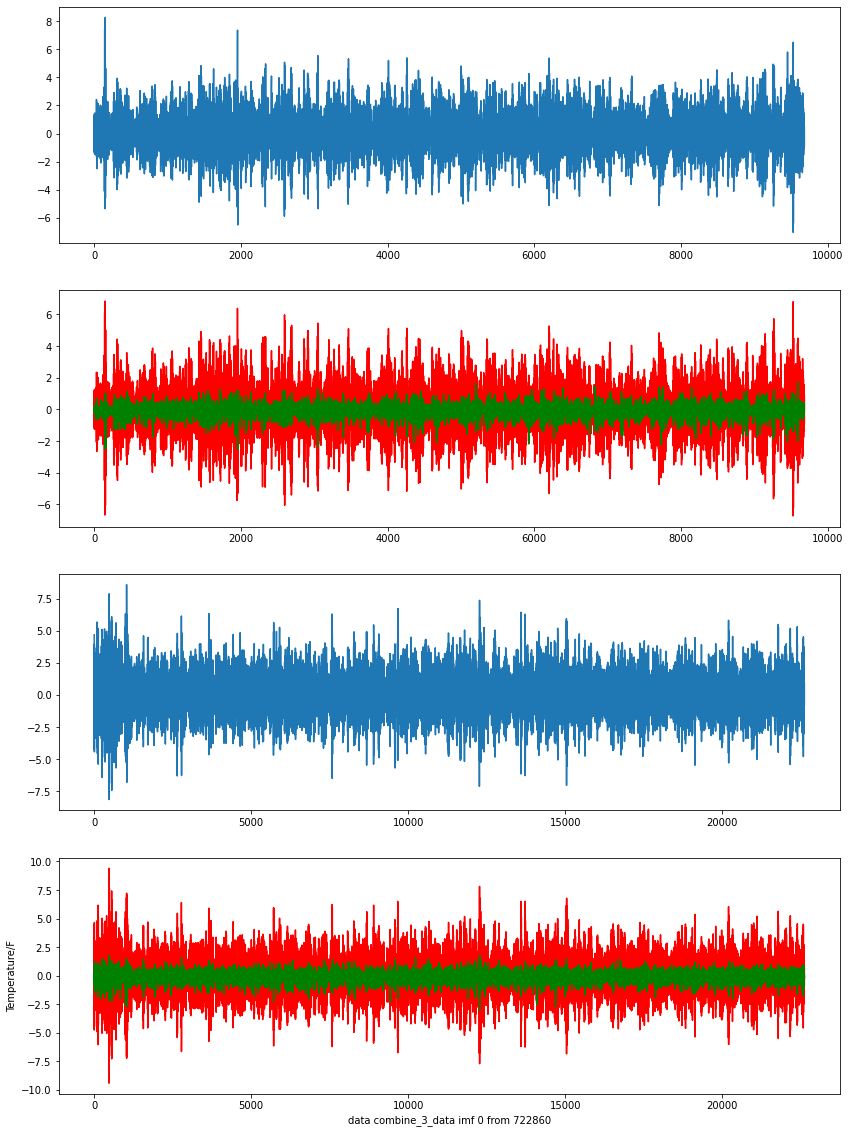

In [9]:
name = "combine_3_data"
error = []
train_set_avg = np.load(f"./npy/avg_%s.npy"%SITE_CODE)
train_set_min = np.load(f"./npy/min_%s.npy"%SITE_CODE)
train_set_max = np.load(f"./npy/max_%s.npy"%SITE_CODE)

print(train_set_max[3][432] == train_set_avg[3][432])
tf.keras.backend.clear_session()

for i in range(len(train_set_avg)):
    train_sub_avg = train_set_avg[i]
    train_sub_min = train_set_min[i]
    train_sub_max = train_set_max[i]
    
    train_index = int(len(train_set_avg[0])*.7+5/9)
    
    (train_data_avg, train_label), (test_data_avg, test_label) = publicMethod.generate(train_index, train_sub_avg)
    (train_data_min, _), (test_data_min, _) = publicMethod.generate(train_index, train_sub_min)
    (train_data_max, _), (test_data_max, _) = publicMethod.generate(train_index, train_sub_max)

    train_data = np.concatenate([train_data_avg, train_data_min, train_data_max], axis = 1)
    test_data = np.concatenate([test_data_avg, test_data_min, test_data_max], axis = 1)
    
    # print(train_data_avg[0] == train_data_min[0], train_set[0])
    
    model = construct_model(train_data, train_label, test_data, test_label)
    
    mse_test = np.sum((model.predict(test_data) - test_label.reshape(-1, 1))**2)/len(test_label)
    mse_train = np.sum((model.predict(train_data) - train_label.reshape(-1, 1))**2)/len(train_label)
    
    fail_safe, index = True, 0
    base_line = np.sum((train_sub_avg[1:] - train_sub_avg[:-1])**2)/(len(train_sub_avg)-1)
    
    """while mse_test >= base_line/(len(train_set_avg)-i+1) and fail_safe:
        print("-------------------------------------------------------------------")
        index += 1
        print(f"\bEpoch:{index}\nMSE\nTRAIN:{mse_train}\tTEST:{mse_test}\nBase_line:{base_line}\tDIFFERENT:{abs(base_line - mse_test)}\nTARGET:{base_line/(len(train_set_avg)-i+1)}\033[0m")
        model = retrain(model, train_data, train_label, test_data, test_label)
        mse_test = np.sum((model.predict(test_data) - test_label.reshape(-1, 1))**2)/len(test_label)
        mse_train = np.sum((model.predict(train_data) - train_label.reshape(-1, 1))**2)/len(train_label)
            
        if index == 10:
            fail_safe = False"""
    
    
    print(f"\bEpoch:{index}\nMSE\nTRAIN:{mse_train}\tTEST:{mse_test}\nBase_line:{base_line}\tDIFFERENT:{abs(base_line - mse_test)}\nTARGET:{base_line/(len(train_set_avg)-i+1)}\033[0m")
    plot(model.predict(test_data), test_label, model.predict(train_data), train_label, i, name)
    error.append(np.sum(abs(model.predict(train_data) - train_label.reshape(-1, 1)))/len(train_label))
        
    tf.saved_model.save(model, SAVE_PATH+f'{PROJECT_PATH}/{SITE_CODE}_{name}_imf{i}.params')
    print("-------------------------------------------------------------------")
    # tf.keras.backend.clear_session()

plt.bar(range(len(error)), error)
plt.xlabel("index of imf")
plt.ylabel("Error (MAE)")
plt.title("Error Comparision")
plt.savefig(f"{SAVE_PATH}/fig/MAE_Error_Compare_{name}_%s.jpg"%SITE_CODE)
plt.show()

In [ ]:
%tensorboard --logdir logs/scalars

FileNotFoundError: [Errno 2] No such file or directory: 'tf_model_compare_params/tf_model_params_relu_722860_20210804-204124/fig/MAE_Error_Compare_combine_3_data_722860.jpg'

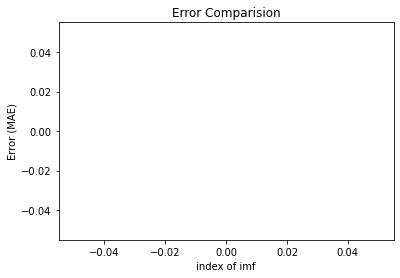

In [10]:
plt.bar(range(len(error)), error)
plt.xlabel("index of imf")
plt.ylabel("Error (MAE)")
plt.title("Error Comparision")
plt.savefig(f"{SAVE_PATH}/fig/MAE_Error_Compare_{name}_%s.jpg"%SITE_CODE)
plt.show()